# Q.1 Image Classification

*   Akshay Bankar (2019201011)



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive




> Install OpenCV's contib library to be able to use SIFT feature extraction.



In [1]:
!pip3 install opencv-contrib-python==3.3.0.9

     |████████████████████████████████| 14.8MB 315kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30




> Import required libraries



In [0]:
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
import pickle

## Classification :

*   SIFT features and Bag-of-Visual words
*   Histogram of Oriented Gradient features and Bag-of-Visual words.

**Bag of visual words:** Idea of bag of visual words (BOVW) is to represent an image as a set of features. Features consists of keypoints and descriptors. Keypoints are the “stand out” points in an image. And descriptor is the description of the keypoint. We use the keypoints and descriptors to construct vocabularies and represent each image as a frequency histogram of features that are in the image.

Steps in building BoVW  :
*   Detect features and extract descriptors from each image :

> SIFT features : It is 128x1 size descriptor for each keypoint of an image.

> HoG features : Build weighted histogram of gradients of the image. I used 9 bins in the histogram in 16x16 cell which results in (9*4)x1 = 36x1 length feature vector. Center of each cluster will be used as the visual dictionary’s vocabularies.

*  Clustering : Perform clustering on the descriptors using K-meanas. The 

> For SIFT based method : Obatined 800 clusters centers using K-means.

> For HoG based : Obatined 400 clusters centers.

*  Create BoVW : For each image, make frequency histogram from the vocabularies and the frequency of the vocabularies in the image. Those histograms are our bag of visual words (BOVW).


>  Below are the functions which extract SIFT features for the complete dataset, performs K-means clustering and finds vocabularies.









In [0]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def getImage(img_mat, plot=False):
    assert img_mat.shape in [(3072,), (3072, 1)] # sanity check
    r_channel = img_mat[:1024].reshape(32, 32)
    g_channel = img_mat[1024: 2 * 1024].reshape(32, 32)
    b_channel = img_mat[2 * 1024:].reshape(32, 32)
    image_repr = np.stack([r_channel, g_channel, b_channel], axis=2)
    assert image_repr.shape == (32, 32, 3) # sanity check
    if plot:
        import matplotlib.pyplot as plt
        plt.imshow(image_repr), plt.show(block=False)

    return image_repr

def getSIFT(img):
    sift = cv2.xfeatures2d.SIFT_create()
    if img.shape in [(3072, 1), (3072,)]: img = getImage(img)
    kps, des = sift.detectAndCompute(img, None)
    return des if des is not None else np.array([]).reshape(0, 128)

def load_images_SIFT(path):
    data_np = []
    labels_np = []
    for i in range(5):
        data_dict = unpickle(path+"/data_batch_"+str(i+1))
        data_np.append(data_dict[b'data'])
        labels_np.append(data_dict[b'labels'])
        print("Batch ", i+1, " data loaded")
    #label_list = ['airplane', 'automobile', 'bird', 'cat', 
    #              'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    descriptor_list = []
    sift_vectors = {str(key): [] for key in range(10)} 
    #categorywise_sift = np.empty(dtype=np.float64)
    for i in range(len(data_np)):
        for j in range(len(data_np[i])):
            feature = getSIFT(data_np[i][j])
            #categorywise_sift[labels_np[i]].append(feature)
            descriptor_list.extend(feature)
            sift_vectors[str(labels_np[i][j])].append(feature)
        print("SIFT of batch ",i+1," calculated")
    #for i in range(len(label_list)):
    #    images[label_list[i]] = categorywise_sift[i]
    return [descriptor_list, sift_vectors, labels_np]

def kmeans(k, descriptor_list):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=666)
    kmeans.fit(descriptor_list) #kmeans.partial_fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
def image_class(all_bovw, centers):
    #label_list = ['airplane', 'automobile', 'bird', 'cat', 
    #              'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    dict_feature = {key: [] for key in range(10)} 
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature
  
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind



> The funcitons below extract HoG features for the complete datset. It uses following parameters :

> Num of bins = 9, Window size = 16x16, Block size = Cell size = 8x8





In [0]:
def load_images_hog(path):
    data_np = []
    labels_np = []
    for i in range(5):
        data_dict = unpickle(path+"/data_batch_"+str(i+1))
        data_np.append(data_dict[b'data'])
        labels_np.append(data_dict[b'labels'])
        print("Batch ", i+1, " data loaded")
    #label_list = ['airplane', 'automobile', 'bird', 'cat', 
    #              'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    descriptor_list = []
    hog_vectors = {str(key): [] for key in range(10)} 
    #categorywise_sift = np.empty(dtype=np.float64)
    for i in range(len(data_np)):
        for j in range(len(data_np[i])):
            feature = getHOG(data_np[i][j])
            #categorywise_sift[labels_np[i]].append(feature)
            descriptor_list.extend(feature)
            hog_vectors[str(labels_np[i][j])].append(feature)
        print("HoG of ", i+1," batch calculated")
    #for i in range(len(label_list)):
    #    images[label_list[i]] = categorywise_sift[i]
    return [descriptor_list, hog_vectors, labels_np]
def getHOG(image):
    winSize = (16,16)
    blockSize = (8,8)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 4
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (0,0)#(8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    return hist

## Classification using SIFT + BoVW

> **Load datset and compute SIFT features **



In [4]:
label_dict = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 
                  'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

feature_list = load_images_SIFT("/content/drive/My Drive/SMAI/Assignment-2/q1/cifar-10-python/cifar-10-batches-py")
print("SIFT Feature list loaded and computed")

descriptor_list = feature_list[0] 

# Takes the sift features that is seperated class by class for train data
all_bovw_feature = feature_list[1]
data_labels = feature_list[2]

Batch  1  data loaded
Batch  2  data loaded
Batch  3  data loaded
Batch  4  data loaded
Batch  5  data loaded
SIFT of batch  1  calculated
SIFT of batch  2  calculated
SIFT of batch  3  calculated
SIFT of batch  4  calculated
SIFT of batch  5  calculated
SIFT Feature list loaded and computed




> **Perform K-means clustering of the SIFT features with k = 800. This finds us the visual words.**



In [5]:
visual_words = kmeans(800, descriptor_list)
print("KMeans computed")

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=800. Setting it to 3*k
  init_size=init_size)


KMeans computed




> **For the vocabularies computed above create BoVW of the images. Each image will have a feature descriptor of size 800x1 corresponding to the k-means centers.**

> **Save the computed BoVW to avoid re-computations.**





In [6]:
bovw_train = image_class(all_bovw_feature, visual_words)
print("Visual words computed")
with open("/content/drive/My Drive/SMAI/Assignment-2/q1/bovw_train.txt", "wb") as fp:   #Pickling
    pickle.dump(bovw_train, fp)
#np.savez("bovw_train", bovw_train)
print("Visual words written") 

Visual words computed
Visual words written




> **Load the BoVW computed and saved above.**



In [23]:
bovw_train = np.load("/content/drive/My Drive/SMAI/Assignment-2/q1/bovw_train.txt", allow_pickle=True)
final_label = []
final_feature = []
for key, value in bovw_train.items():
    for val in value:
      final_label.append(int(key))
      final_feature.append(val)
print(np.shape(final_label))
print(np.shape(final_feature))

(50000,)
(50000, 800)




> **Plot feature vectors**



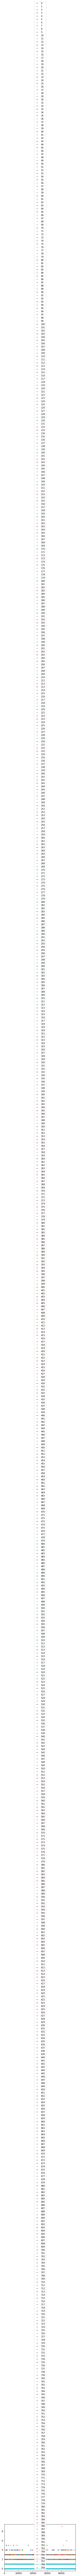

In [24]:
import pandas as pd
dataframe = pd.DataFrame(final_feature)
dataframe.head()
dataframe.plot(style='.')



> **For validation split the dataset into training and testing.**

> **Train this visual dictionary using SVM.**





In [4]:
X_train, X_test, y_train, y_test = train_test_split(final_feature, final_label, test_size=0.2, random_state=666)
print(len(X_train), len(X_test), len(y_train), len(y_test))
#clf = linear_model.SGDClassifier(max_iter=10, alpha = 0.01, loss='hinge', random_state = 666)
clf = SVC()
clf.fit(X_train, y_train)

40000 10000 40000 10000


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



> **Predict the labels of the test data and find the accuracy.**



In [5]:
clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print("Accuracy : ",accuracy)

Accuracy :  0.3042


## Classification Using HoG + BoVW

> **Load datset and compute HoG features **



In [13]:
feature_list = load_images_hog("/content/drive/My Drive/SMAI/Assignment-2/q1/cifar-10-python/cifar-10-batches-py")
print("HOG Feature list loaded and computed")
descriptor_list = feature_list[0] 
# Takes the HoG features that is seperated class by class for train data
all_bovw_feature = feature_list[1]
data_labels = feature_list[2]

Batch  1  data loaded
Batch  2  data loaded
Batch  3  data loaded
Batch  4  data loaded
Batch  5  data loaded
HoG of  1  batch calculated
HoG of  2  batch calculated
HoG of  3  batch calculated
HoG of  4  batch calculated
HoG of  5  batch calculated
HOG Feature list loaded and computed




> **Perform K-means clustering of the HoG features with k = 400. This finds us the visual words.**



In [15]:
visual_words = kmeans(400, descriptor_list)
print("KMeans computed")

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)
/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


KMeans computed




> **Save the computed BoVW to avoid re-computations.**



In [16]:
bovw_train = image_class(all_bovw_feature, visual_words)
print("Visual words computed")
with open("/content/drive/My Drive/SMAI/Assignment-2/q1/bovw_train_hog.txt", "wb") as fp:   #Pickling
    pickle.dump(bovw_train, fp)
print("Visual words written") 

Visual words computed
Visual words written




> **Load the BoVW computed and saved above.**



In [17]:
bovw_train = np.load("/content/drive/My Drive/SMAI/Assignment-2/q1/bovw_train_hog.txt", allow_pickle=True)
final_label = []
final_feature = []
for key, value in bovw_train.items():
    for val in value:
      final_label.append(int(key))
      final_feature.append(val)
print(np.shape(final_label))
print(np.shape(final_feature))

(50000,)
(50000, 400)




> **Plot feature vectors**



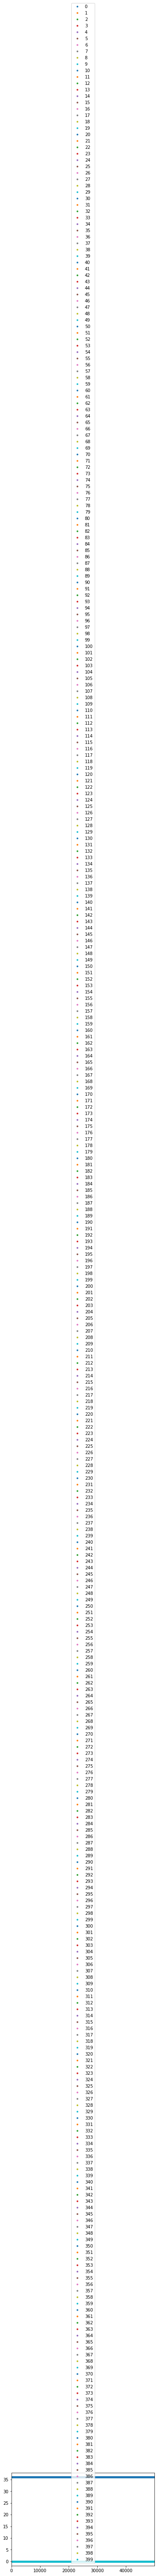

In [22]:
import pandas as pd
dataframe = pd.DataFrame(final_feature)
dataframe.head()
dataframe.plot(style='.')



> **Train this visual dictionary using SVM.**



In [18]:
X_train, X_test, y_train, y_test = train_test_split(final_feature, final_label, test_size=0.2, random_state=666)
print(len(X_train), len(X_test), len(y_train), len(y_test))
#clf = linear_model.SGDClassifier(max_iter=10, alpha = 0.01, loss='hinge', random_state = 666)
clf = SVC()
clf.fit(X_train, y_train)

40000 10000 40000 10000


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)



> **Predict the labels of the test data and find the accuracy.**



In [19]:
clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print("Accuracy using HoG + BoVW : ",accuracy)

Accuracy using HoG + BoVW :  0.0961
